In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sklearn
import os
import os
import numpy as np
import concurrent.futures
from skimage.feature import hog
from skimage import exposure
from skimage.feature import local_binary_pattern
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from PIL import Image
import sys

# os.environ['NOVA_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps'
os.environ['NOVA_HOME'] = '/home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA'

sys.path.insert(1, os.getenv('NOVA_HOME'))
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from src.preprocessing.preprocessing_utils import get_image_focus_quality 
from src.preprocessing.preprocessing_utils import rescale_intensity, fit_image_shape

%reload_ext autoreload
%autoreload 2
%aimport

%matplotlib inline

NOVA_HOME: /home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA
Modules to reload:
all-except-skipped

Modules to skip:



# Utils

In [17]:
# Load images
def get_npy_files(path):
    npy_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    return npy_files

import skimage


def get_metrics_processed(tile):
  metrics = ()
  for c in range(tile.shape[-1]):
    metrics += get_metrics(tile[...,c])
    
  return metrics

def get_metrics(tile, as_string=False):
    sharpness_brenner = get_image_focus_quality(tile)    
    if as_string:
        return f"Brenner: {round(sharpness_brenner, 3)}"
    return sharpness_brenner

# def get_metrics_columns():
#   return ["Path", "Quality", "Target_SNR", "Target_Sharpness_Laplacian", "Target_Var",
#            'Target_Sharpness_Brenner', "Target_Entropy", "Target_Sigma", "Target_HighFreq", "DAPI_SNR", "DAPI_Sharpness_Laplacian",
#             "DAPI_Var", 'DAPI_Sharpness_Brenner', "DAPI_Entropy", "DAPI_Sigma", "DAPI_HighFreq"]


def run_dim_reduction(dim_red, images, labels=None, show=True):
  # Perform PCA
  images = images.reshape(images.shape[0], -1)
  reduced = dim_red.fit_transform(images)
  
  if not show:
    return reduced
  
  if labels is None:
    plt.scatter(reduced[:,0], reduced[:,1])
    plt.show()
    return reduced
  
  
  labels_unique = np.unique(labels)
  
  for l in labels_unique:
    indexes = labels == l
    plt.scatter(reduced[indexes,0], reduced[indexes,1], alpha=0.5)
  plt.legend(labels_unique)
  plt.show()
  
  return reduced 

def plot_images(images, vmin=0,vmax=1000):
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(images[i,...,0])#, vmin=vmin,vmax=vmax)
        ax[0].set_title("Target")
        ax[1].imshow(images[i,...,1])#, vmin=vmin,vmax=vmax)
        ax[1].set_title("Nucleus")
        plt.show()
        
def load_tiles(paths):
  paths_split = map(lambda x: (x.rsplit('_',1)[0], int(x.rsplit('_',1)[1])), paths.reshape(-1,))
  tiles = []
  for filename, tile_number in paths_split:
    t = np.load(filename)[tile_number, ...]
    tiles.append(t)
    
  tiles = np.stack(tiles)
  return tiles



def get_outliers(df, feature, split=False, iqrs=1.5):
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = df[feature] < Q1 - iqrs* IQR
    higher = df[feature] > Q3 + iqrs*IQR
    if split:
        # Determine outliers using IQR
        outliers_lower = df[lower]
        outliers_higher = df[higher]
        return outliers_lower, outliers_higher
    
    # Determine outliers using IQR
    outliers = df[(lower ) | (higher)]
    
    return outliers

def show_images(df, max_samples = 10):
    for ind, path in enumerate(df.Path.values):
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        target_path = os.path.join(d, path)
        show_processed_tif(target_path)
        # His DAPI
        # path_l = target_path.split("/")
        # path_l[-2] = 'DAPI'
        
        # file_name = path_l[-1].split("_")
        # dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        # dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        # print(dapi_file_name)

        # show_processed_tif(dapi_file_name)
        print('--------------------------------')
        
def get_dapi_file_name(path):
    site_path, tile_number = path.rsplit('_',1)
    path_l = site_path.split("/")
    path_l[-2] = 'DAPI'

    file_name = path_l[-1].split("_")
    dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
    dapi_file_name = "/".join([*path_l[:-1], f'{dapi_file_name}_{tile_number}'])
    
    return dapi_file_name
        
def show_tiles(df, max_samples=10, rescale_tile=False):
    for ind, path in enumerate(df.Path.values):
        site_path, tile_number = path.rsplit('_',1)
        tile_number = int(tile_number)
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        show_tile(site_path, tile_number, rescale_tile)
        # His DAPI
        path_l = site_path.split("/")
        path_l[-2] = 'DAPI'
        
        file_name = path_l[-1].split("_")
        dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        print(dapi_file_name)

        show_tile(dapi_file_name, tile_number, rescale_tile)
        print('--------------------------------')
        
# def save_to_mapping(mappings, marker, metric_name, low_threshold, high_threshold):
#     mappings[marker] = {
#         metric_name: {
#             'low_threshold': low_threshold,
#             'high_threshold': high_threshold
#         }
#     }

def init_mappings(markers=[], filepath=None):
    if filepath is not None:     
        if os.path.exists(filepath):
            mappings = pd.read_csv(filepath, index_col=0)
            return mappings
        
    mappings = pd.DataFrame(columns=['Lower_bound', 'Upper_bound'], index=markers)

    return mappings
        
def save_to_mapping(filepath, mappings, marker, value, is_upper_bound):
    col = 'Upper_bound' if is_upper_bound else 'Lower_bound' 
    mappings.loc[marker, col] = value
    
    mappings.to_csv(filepath)
    print(f"File saved to {filepath}")
    
    
def processed_path_to_raw_paths(path):
    path_splited = path.split(os.sep)
    filename = path_splited[-1]
    filename_split = filename.split('_')
    rep = filename_split[0]
    panel = filename_split[4]
    line = filename_split[5]
    filename_new = '_'.join(filename_split[1:4])
    batch = path_splited[-5]
    batch = batch.split('_')[0]
    cond = path_splited[-3]
    marker = path_splited[-2]
    
    ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/Cory/indi-image-pilot-20241128", batch, line, panel, cond, rep, marker, f'{filename_new}.tif')
    # ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk", batch, line, panel, cond, rep, marker, f'{filename_new}.tif')
    return ret

def raw_path_to_processed_path(path):
    path_splited = path.split(os.sep)
    filename = os.path.splitext(path_splited[-1])[0]
    rep = path_splited[-3]
    panel = path_splited[-5]
    line = path_splited[-6]
    batch = path_splited[-7]
    batch = f"{batch}_16bit_no_downsample"
    cond = path_splited[-4]
    marker = path_splited[-2]
    
    ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/", batch, line, cond, marker, f'{rep}_{filename}_{panel}_{line}_processed.npy')
    return ret


# d = '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/'
d = '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/Cory/indi-image-pilot-20241128/'

def show_label(path):
    path_l = path.split("/")
    return path_l[-7:]
    
def show_processed_tif(path):
    # read the image stack
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH) 
    img = fit_image_shape(img, (1024, 1024))
    # rescale pixel intensities
    img = rescale_intensity(img)
    
    # show the image with grid 
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(path), color='purple')
    print(get_metrics(img, True))
    print(f"Img shape: {img.shape}")
    plt.show()
    
def show_tile(site_path, tile_number, rescale_tile=False):
    # read the image stack
    img = cv2.imread(site_path, cv2.IMREAD_ANYDEPTH) 
    img = fit_image_shape(img, (1024, 1024))
    # rescale pixel intensities
    img = rescale_intensity(img)
    
    row_ind = tile_number // 10
    col_ind = tile_number % 10
    img = img[row_ind * 100 : (row_ind + 1) * 100, col_ind * 100 : (col_ind + 1) * 100]
    
    print(f"img shape: {np.asarray(img).shape}")
    
#     # Check dead cells?
#     img_uint8 = img.astype(np.uint8)
#     # Apply Gaussian blur
# #     gray_blurred = cv2.GaussianBlur(img_uint8, (9, 9), 0)

#     # Apply Hough Circle Transform
#     # Adjust the parameters, especially minRadius and maxRadius, to detect small circles
#     circles = cv2.HoughCircles(img_uint8, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
   
    
    if rescale_tile:
        print("NOTICE! Rescaling also the tile!!!!!")
        img = rescale_intensity(img)
    
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    
#     if circles is not None:
#         print(f"circles count: {len(circles)}")
#         circles = np.uint16(np.around(circles))
#         for i in circles[0, :]:
#             center = (i[0], i[1])  # circle center
#             radius = i[2]  # circle radius
#             cv2.circle(image, center, radius, (0, 255, 0), 2)
    
#     put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(site_path), color='purple')
    print(get_metrics(img, True))
    plt.show()
    
def crop_frame(original_image):
    # Crop the image by removing a 12-pixel frame from each side
    cropped_image = original_image[12:1012, 12:1012]  
    return cropped_image

def crop_site_to_tiles(img):
    from skimage.util import view_as_blocks
    # Break the cropped image into 64 tiles of size 100x100
    tile_size = 100
    num_tiles = 64

    # Reshape the image into tiles using view_as_blocks from skimage
    tiles = view_as_blocks(img, block_shape=(tile_size, tile_size, 3))

    for i in range(8):
        for j in range(8):
            tile = tiles[i, j]
    return 

def put_tiles_grid(image, ax):
    # assumes 1000x1000 image
    import matplotlib.patches as patches

    # Add dashed grid lines for 64 blocks
    num_blocks = 10
    block_size = 100

    for i in range(1, num_blocks):
        # Draw horizontal dashed lines
        ax.plot([0, 1000], [i * block_size, i * block_size], linestyle='--', lw=1, alpha=0.5, color='pink')

        # Draw vertical dashed lines
        ax.plot([i * block_size, i * block_size], [0, 1000], linestyle='--', lw=1, alpha=0.5, color='pink')

    # Remove x and y axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a title
    plt.title('Image with Dashed Grid of 64 Blocks')

def update_all_mappings(mappings, thresholds, df):
    metric_name = 'Target_Sharpness_Brenner'
    percentiles_to_describe = np.arange(0, 1.0001, 0.0001)

    # Iterate over the rows and fill the thresholds
    for marker in mappings.index:
        if marker in thresholds and thresholds[marker] is not None:
            df_marker = df.loc[df['Marker'] == marker]
            percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
            mappings.loc[marker, "Lower_bound"] = round(percentiles[f'{thresholds[marker][0]}%'], 2)
            mappings.loc[marker, "Upper_bound"] = round(percentiles[f'{thresholds[marker][1]}%'], 2)
    return mappings

# Main

In [18]:
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/outliers_detection/raw_metrics_all_batches_all_metrics_site_fix.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/outliers_detection/raw_metrics_all_batches_brenner_site_dNLS.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/sandbox/outliers_detection/brenner_values/raw_metrics_fus_fixed200224_2.csv")

# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/spd/brenner/raw_metrics250324.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/Opera/brenner/raw_metrics250324.csv")

# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/Opera18Days/brenner/raw_metrics210524.csv")
df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/NIH/brenner/raw_metrics021224_all.csv")

df

,Path,RootFolder,Marker,Condition,CellLine,Batch_Rep,Rep,Batch,Target_Sharpness_Brenner
0,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,ANAX11,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,3911.732552
1,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,ANAX11,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,5572.411014
2,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,ANAX11,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,4809.356661
3,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,ANAX11,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,3724.485654
4,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,ANAX11,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,5137.414521
...,...,...,...,...,...,...,...,...,...
130995,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,NCL,stress,WT,batch3/rep8,rep8,batch3,806.355745
130996,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,NCL,stress,WT,batch3/rep8,rep8,batch3,1303.443933
130997,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,NCL,stress,WT,batch3/rep8,rep8,batch3,1000.440872
130998,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,NCL,stress,WT,batch3/rep8,rep8,batch3,832.100729


In [19]:
df['Marker'].value_counts()

Marker
DAPI            32750
TUJ1            23825
ANAX11           3000
SNCA             3000
TDP43            3000
P54              3000
CD41             3000
KIF5A            3000
FMRP             3000
G3BP1            3000
SQSTM1           3000
MitoTracker      2975
NCL              2975
PSD95            2975
CLTC             2975
LAMP1            2975
FUS              2975
PURA             2975
Calreticulin     2975
TIA1             2975
NEMO             2950
DCP1A            2950
TOMM20           2950
Phalloidin       2950
GM130            2950
PML              2950
PEX14            2950
Name: count, dtype: int64

In [20]:
# mappings = {}
counts = df['Marker'].value_counts()
all_markers = df['Marker'].unique()
print(len(all_markers))
print(all_markers)

27
['ANAX11' 'DAPI' 'SNCA' 'TUJ1' 'DCP1A' 'NEMO' 'CLTC' 'PSD95' 'CD41' 'P54'
 'TDP43' 'GM130' 'Phalloidin' 'TOMM20' 'Calreticulin' 'LAMP1' 'FMRP'
 'SQSTM1' 'G3BP1' 'KIF5A' 'PEX14' 'PML' 'PURA' 'TIA1' 'FUS' 'MitoTracker'
 'NCL']


In [21]:
# mappings_filepath = "/home/labs/hornsteinlab/Collaboration/MOmaps/manuscript/markers_focus_boundries/markers_focus_boundries_opera18days.csv"
mappings_filepath = "/home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA/manuscript/markers_focus_boundries/markers_focus_boundries_NIH.csv"
mappings = init_mappings(markers=all_markers, filepath=mappings_filepath)
mappings

,Lower_bound,Upper_bound
ANAX11,1552.89,12113.94
DAPI,526.69,5325.03
SNCA,1875.86,9472.52
TUJ1,1780.59,27767.24
DCP1A,3894.81,7877.93
NEMO,5658.35,22129.45
CLTC,3112.89,14333.32
PSD95,3126.78,19160.68
CD41,1043.58,12823.04
P54,1912.99,6289.01


In [22]:
# table_data = {
#     'CLTC': (1500, 20000),
#     'DAPI': (200, 7500),
#     'PSD95': (9771, 35041),
#     'FMRP': (1500, 10000),
#     'Phalloidin': (1702, 16000),
#     'SQSTM1': (2870, 17930),
#     'CD41': (4962, 20000),
#     'NONO': (0, 10000), #None to 0
#     'TDP43': (823, 14039),
#     'Calreticulin': (2000, 28313),
#     'LAMP1': (2171, 11318),
#     'ANXA11': (0, 14633),#None to 0
#     'SNCA': (3529, 23953),  
#     'G3BP1': (0, 9945),#None to 0
#     'KIF5A': (2118, 13717),  
#     'PURA': (2248, 7703),  
#     'FUS': (421, 7748), 
#     'NCL': (544, 4067),  
#     'GM130': (0, 4284),#None to 0
#     'TOMM20': (4042, 44385),
#     'DCP1A': (0, 14931),  #None to 0
#     'NEMO': (15491, 44143),  
#     'PEX14': (3353, 20000), 
#     'PML': (2000, 21338), 
#     'mitotracker': (5270, 20000) 
# }

Plot distribution

In [23]:
# import seaborn as sns

# # Plotting
# plt.figure(figsize=(20,8))
# sns.boxplot(x='Marker', y='Target_Sharpness_Brenner', data=df)
# plt.xticks(rotation=45)
# plt.title('Brenner Values per marker')

# plt.show()

# Examine Brenner

Showing images between %50 - 60
Number of DAPI images in threshold 1778.1495919493457 (50%) (and 1953.4908888086045 (60%)): 3275


CellLine
WT                 1381
FUSHomozygous       730
FUSRevertant        584
FUSHeterozygous     580


Condition
Untreated    2620
stress        655


0
Brenner: 1861.765
Img shape: (1024, 1024)


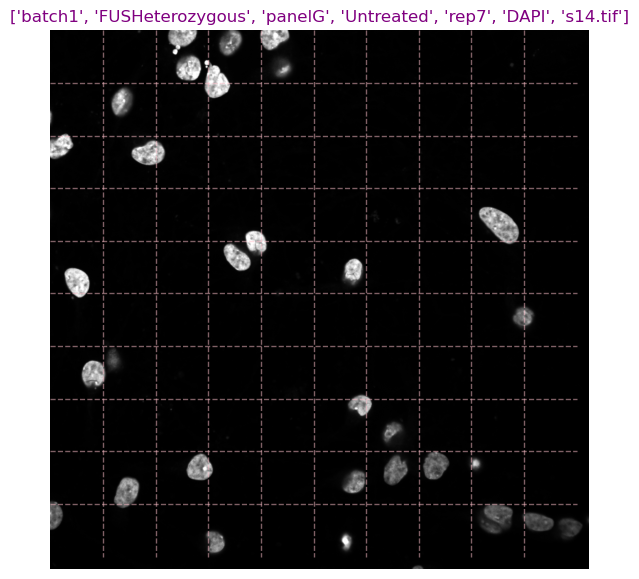

--------------------------------
1
Brenner: 1907.454
Img shape: (1024, 1024)


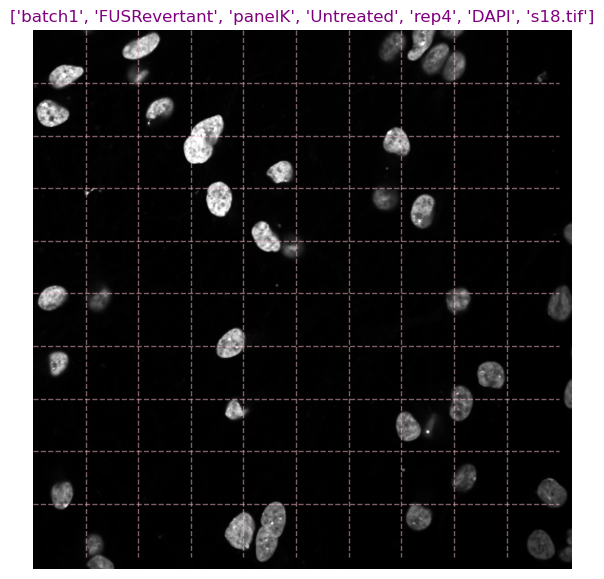

--------------------------------
2
Brenner: 1876.753
Img shape: (1024, 1024)


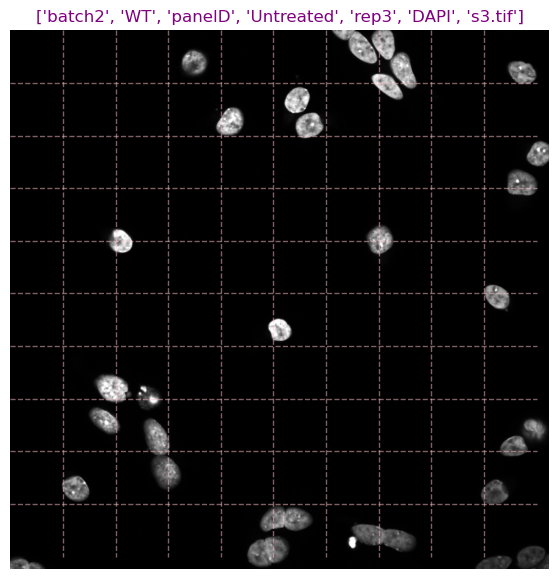

--------------------------------
3
Stopping at 3. There are 3275 images in total


In [24]:
#################### SAFE ZONE TO CHANGE ###############

marker = 'DAPI' # MAKRENAME
# [marker] Options:
# ['ANAX11' 'DAPI' 'SNCA' 'TUJ1' 'DCP1A' 'NEMO' 'CLTC' 'PSD95' 'CD41' 'P54'
#  'TDP43' 'GM130' 'Phalloidin' 'TOMM20' 'Calreticulin' 'LAMP1' 'FMRP'
#  'SQSTM1' 'G3BP1' 'KIF5A' 'PEX14' 'PML' 'PURA' 'TIA1' 'FUS' 'MitoTracker'
#  'NCL']

per_min = 50
per_max = 60
max_samples = 3

###################### END OF SAFE ZONE ###################



metric_name = 'Target_Sharpness_Brenner'
percentiles_to_describe = np.arange(0, 1.0001, 0.0001)
df_marker = df.loc[df['Marker'] == marker]
percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

print(f'Showing images between %{per_min} - {per_max}')
threshold = percentiles[f'{per_min}%']
threshold_second = percentiles[f'{per_max}%']

c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second) 

# threshold
df_marker_filtered = df_marker[c]
# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)

print(f"Number of {marker} images in threshold {threshold} ({per_min}%) (and {threshold_second} ({per_max}%)): {len(df_marker_filtered)}")
print("\n")
print(df_marker_filtered['CellLine'].value_counts().to_string())
print("\n")
print(df_marker_filtered['Condition'].value_counts().to_string())
print("\n")
show_images(df_marker_filtered, max_samples=max_samples)    

# Set Brenner

In [25]:
thresholds = {
    "DAPI": (0.5, 99.95),
    "FUS": (0.2, 99.9),
    "ANAX11": (2, 100),
    "G3BP1": (0.05, 99.95),
    "SNCA": (10, 100),
    "TUJ1": (0.2, 99.9),
    "DCP1A": (0.5, 85),
    "NEMO": (1, 99),
    "CLTC": (0.2, 90),
    "PSD95": (20, 90),
    "CD41": (1, 80),
    "P54": (5, 99),
    "TDP43": (2, 99),
    "GM130": (2, 99),
    "Phalloidin": (10, 99.9),
    "TOMM20": (10, 99),
    "Calreticulin": (5, 99.8),
    "LAMP1": (2, 99.5),
    "FMRP": (10, 99.95),
    "SQSTM1": (20, 99.9),
    "KIF5A": (10, 99.9),
    "PEX14": (1, 90),
    "PML": (5, 85),
    "PURA": (0.5, 99.9),
    "TIA1": (1, 99),
    "MitoTracker": (0.5, 99.9),
    "NCL": (0.1, 99.8),
}


In [26]:
mappings = update_all_mappings(mappings, thresholds, df)
mappings.to_csv(mappings_filepath)

In [27]:
mappings

,Lower_bound,Upper_bound
ANAX11,1552.89,12113.94
DAPI,526.69,5325.03
SNCA,1875.86,9472.52
TUJ1,1780.59,27767.24
DCP1A,3894.81,7877.93
NEMO,5658.35,22129.45
CLTC,3112.89,14333.32
PSD95,3126.78,19160.68
CD41,1043.58,12823.04
P54,1912.99,6289.01


# Original code

marker = DAPI, per: 98% (per_second_bound=100%), max_samples = 10, is upper bound: True
Number of DAPI images in threshold 3477.583518033296 (98%) (and 104151.85872576178 (100%)): 655



CellLine
FUSHeterozygous    260
FUSRevertant       166
FUSHomozygous      148
WT                  81
Condition
Untreated    613
stress        42
0
Brenner: 4083.226
Img shape: (1024, 1024)


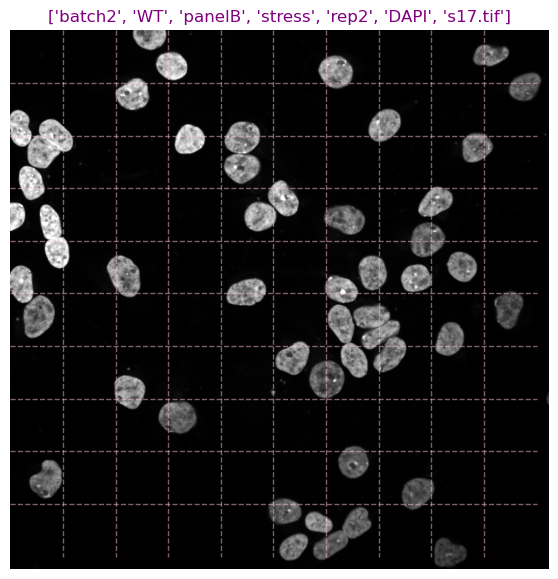

--------------------------------
1
Brenner: 3744.458
Img shape: (1024, 1024)


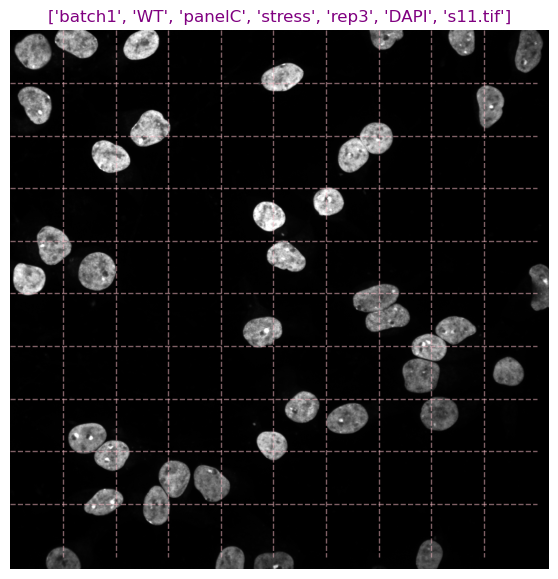

--------------------------------
2
Brenner: 3600.249
Img shape: (1024, 1024)


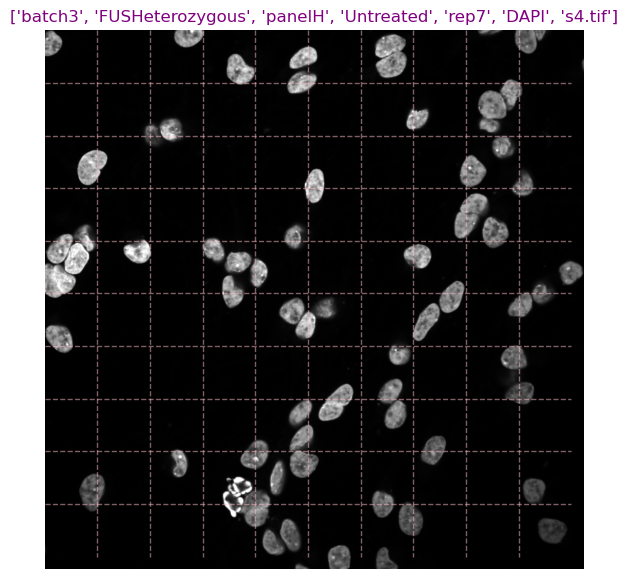

--------------------------------
3
Brenner: 3604.248
Img shape: (1024, 1024)


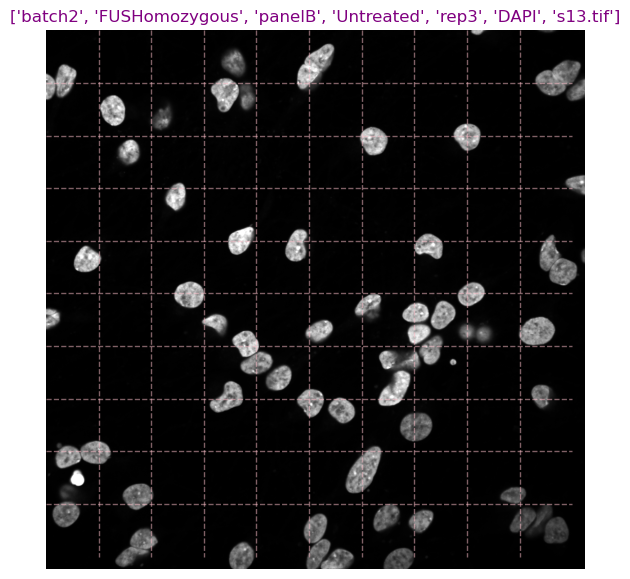

--------------------------------
4
Brenner: 4076.73
Img shape: (1024, 1024)


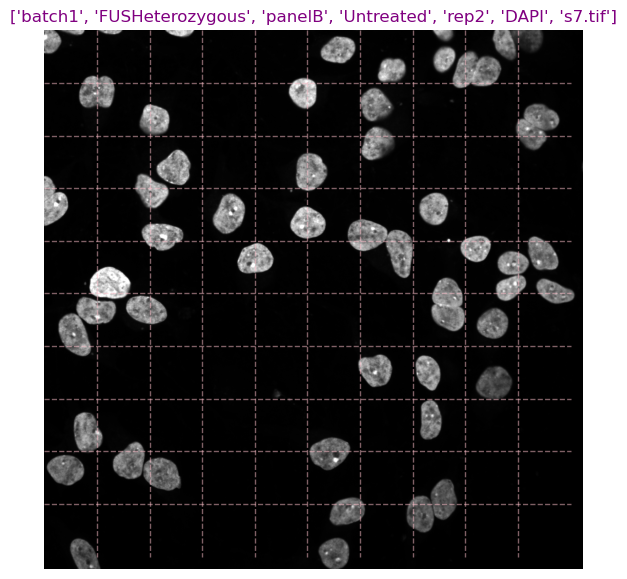

--------------------------------
5
Brenner: 3561.87
Img shape: (1024, 1024)


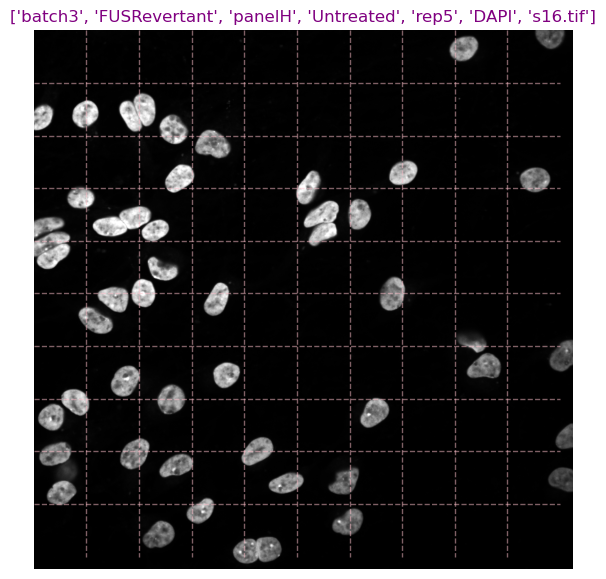

--------------------------------
6
Brenner: 3867.22
Img shape: (1024, 1024)


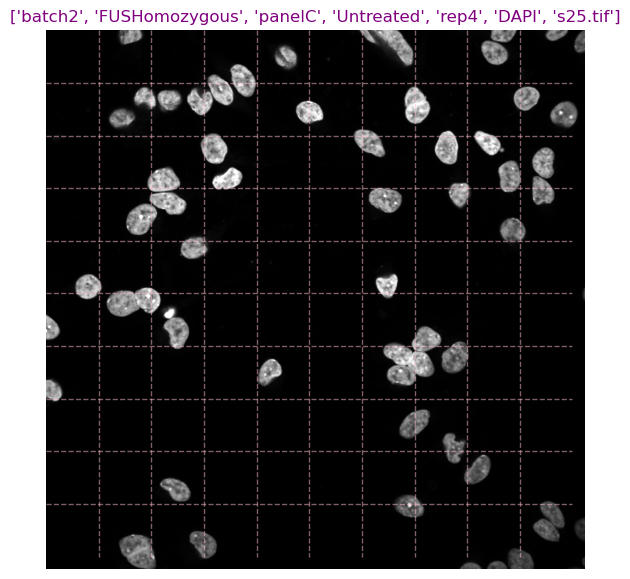

--------------------------------
7
Brenner: 3506.366
Img shape: (1024, 1024)


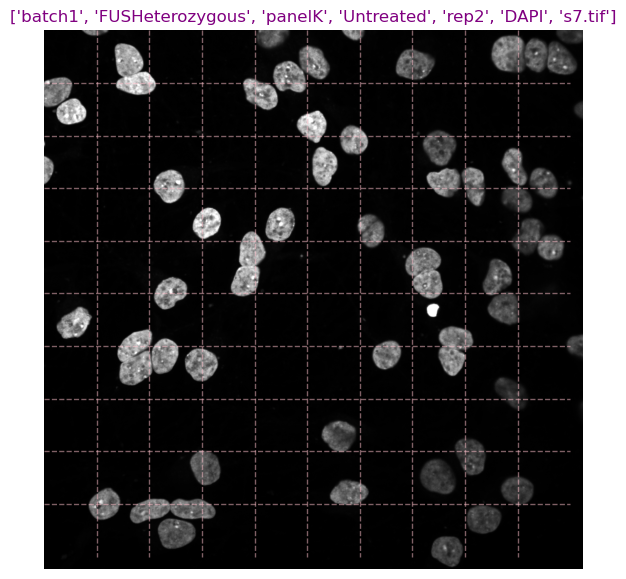

--------------------------------
8
Brenner: 3918.343
Img shape: (1024, 1024)


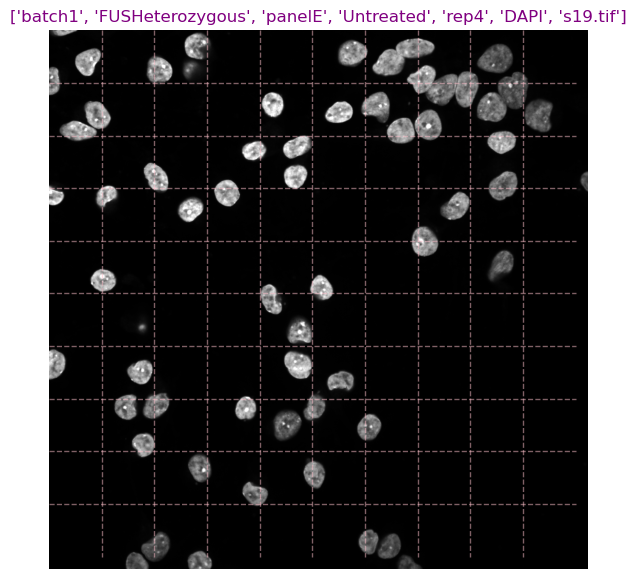

--------------------------------
9
Brenner: 4116.659
Img shape: (1024, 1024)


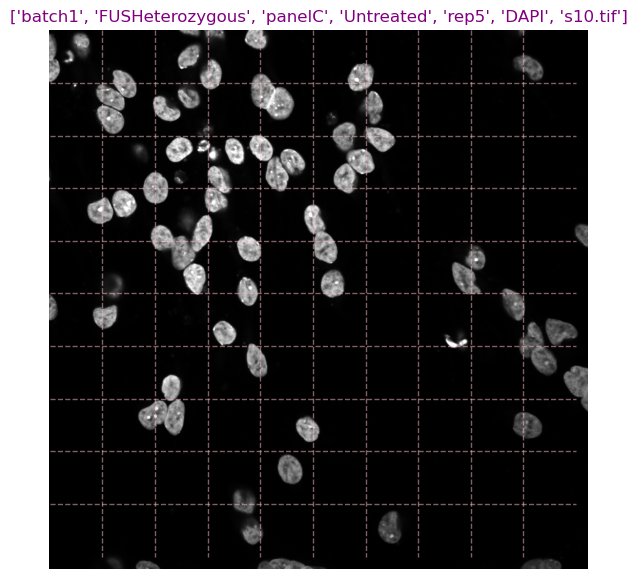

--------------------------------
10
Stopping at 10. There are 655 images in total


OSError: Cannot save file into a non-existent directory: '/home/labs/hornsteinlab/Collaboration/MOmaps/manuscript/markers_focus_boundries'

In [39]:
#################### SAFE ZONE TO CHANGE ###############

marker = 'DAPI' # MAKRENAME
# [marker] Options:
# ['CLTC', 'DAPI', 'PSD95', 'FMRP', 'Phalloidin', 'SQSTM1', 'AGO2',
#        'CD41', 'TDP43', 'HNRNPA1', 'PSPC1', 'Tubulin', 'Calreticulin',
#        'LAMP1', 'ANXA11', 'SNCA', 'G3BP1', 'PURA', 'TOMM20', 'FUS', 'NCL',
#        'GM130', 'KIF5A', 'DCP1A', 'NEMO', 'PEX14', 'PML', 'mitotracker',
#        'NONO', 'VDAC1']


# [per] Options: 0-100
per = 98 # percentile threshold 

# [per] Options: 0-100
# *Optional! if you want to view images between per and another threshold
per_second_bound = None

max_samples = 10 # set max number of images (in threshold) to show

# [is_upper_bound] Options:
# True: upper bound
# False: lower bound
is_upper_bound = True 

show_percentile_plot = False

###################### END OF SAFE ZONE ###################





#########################################

if per_second_bound is None:
    per_second_bound = 100 if is_upper_bound else 0

        
print(f"marker = {marker}, per: {per}% (per_second_bound={per_second_bound}%), max_samples = {max_samples}, is upper bound: {is_upper_bound}")

metric_name = 'Target_Sharpness_Brenner'
percentiles_to_describe = np.arange(0, 1.01, 0.01)
df_marker = df.loc[df['Marker'] == marker]
percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

threshold = percentiles[f'{per}%']
threshold_second = percentiles[f'{per_second_bound}%']

if is_upper_bound:
    c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second)
else:
    c = (df_marker[metric_name]<=threshold) & (df_marker[metric_name]>=threshold_second) 

# threshold
df_marker_filtered = df_marker[c]
# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)

print(f"Number of {marker} images in threshold {threshold} ({per}%) (and {threshold_second} ({per_second_bound}%)): {len(df_marker_filtered)}")
print("\n\n")
print(df_marker_filtered['CellLine'].value_counts().to_string())
print(df_marker_filtered['Condition'].value_counts().to_string())

if show_percentile_plot:
    plt.figure(figsize=(15,6))
    plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
    plt.ylabel('value')
    plt.xlabel('percentile')
    plt.xticks(rotation=90)
    plt.show()

show_images(df_marker_filtered, max_samples=max_samples)    

save_to_mapping(mappings_filepath, mappings, marker, round(threshold,2), is_upper_bound)


-----------------------------------------------------

In [ ]:
import scipy

# percentiles_to_describe=[0,.003,0.005,0.01,0.02,0.03,0.04,0.05,.06,0.07,.08,.09,0.1,.11,.12,.13,.14,.15]
percentiles_to_describe=[.16,.17,.18,.19,.20,.28,.29,.3,.31,.32,.33,.49,.5,.51,.60,.61,.62,.63,.64,.65,.66,.67,.68,.69,.70,.71,.72,.73,.75,.76,.77,.78,.79,.80,.81,.85,.86,.87,.88,.89,.90,.91,.92,.93,.94,.95,.955,.96,.965,.97,.975, .98,.985,.99,1]
marker = 'NONO'
metric_name = 'Target_Sharpness_Brenner'
percentiles = df.loc[df['Marker']==marker, metric_name].describe(percentiles=percentiles_to_describe)
per = 98

# box_plot_percentile = df.loc[df['Marker']==marker, metric_name].describe(percentiles=[.25,.75])
# boxplot_upper_bound = box_plot_percentile["75%"] + 1.5 * scipy.stats.iqr(df.loc[df['Marker']==marker, metric_name])
# boxplot_lower_bound = box_plot_percentile["25%"] - 1.5 * scipy.stats.iqr(df.loc[df['Marker']==marker, metric_name])

# print(f"boxplot_lower_bound = {boxplot_lower_bound}, boxplot_upper_bound = {boxplot_upper_bound},")

# low_threshold = table_data[marker][0]#percentiles[f'{per}%'] # for cellular debris
# high_threshold = table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# low_threshold =percentiles[f'{per}%'] # for cellular debris
high_threshold = percentiles[f'{per}%'] # for out of focus

# low_threshold = boxplot_lower_bound
# high_threshold = 14000.0#2572.455155#23015.740327#boxplot_upper_bound#30000#table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# per = 1
# low_threshold = percentiles[f'{per}%'] # for cellular debris
# high_threshold = percentiles[f'{per}%']#table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# per = "From Mapping"
# low_threshold = markers_dict[marker]['lower_bound'] # debris
# high_threshold = markers_dict[marker]['upper_bound'] # out of focus

max_samples =10

# print(marker, metric_name, low_threshold, high_threshold, f'({per}%)')
# print()
# print(marker, '\n', percentiles)


# c = (df[metric_name]<=low_threshold) #& (df[metric_name]>=percentiles[f'20%'])  
c = (df[metric_name]>=high_threshold) #& (df[metric_name]<=percentiles[f'{per+1}%'] ) #& (df[metric_name]<=25000) # & (df[metric_name]<=percentiles[f'{per+1}%'] )

# c = (df[metric_name]<=9771) & (df[metric_name]>=low_threshold)  
# c = (df[metric_name]>=high_threshold) & (df[metric_name]<=30000 ) #& (df[metric_name]<=25000) # & (df[metric_name]<=percentiles[f'{per+1}%'] )


tmp = df[c]
# print(tmp.shape)
tmp = tmp[(tmp.Marker==marker)]

tmp = tmp.sample(frac=1, random_state=1)

print(tmp.shape, round(tmp.shape[0] * 100.0/counts[marker], 3), 100-round(tmp.shape[0] * 100.0/counts[marker], 3))


plt.figure(figsize=(15,6))
plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
plt.xticks(rotation=90)
plt.show()

show_images(tmp, max_samples=max_samples)    

save_to_mapping(mappings, marker, metric_name, low_threshold, high_threshold)

print("The thresholds map:")
mappings


In [ ]:
# Print top brenners per marker
max_samples = 5
df_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/NIH/brenner/raw_metrics021224_all.csv"

print(f"max_samples = {max_samples}")

df = pd.read_csv(df_path)
print(df.shape)

markers = df['Marker'].unique()
print(markers.shape)

for marker in markers:
    print(marker)
    df_marker = df.loc[df['Marker'] == marker]
    print(f"df_marker shape: {df_marker.shape}")
    df_marker.sort_values('Target_Sharpness_Brenner', ascending=False, inplace=True)
    df_marker_subset = df_marker.iloc[:max_samples]
    show_images(df_marker_subset, max_samples=max_samples)   